In [1]:
%load_ext autoreload
%autoreload 2

import uproot as ur
import awkward as ak
import numpy as np

mac = False

data_path = '/fast_scratch/atlas_images/v01-45/'
if mac:
    data_path = '/Users/swiatlow/Data/caloml/graph_data/'

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [4]:
X = np.load(data_path+'X_4.npy')

In [6]:
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000)))) #one hot

In [7]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)


In [8]:
from energyflow.utils import data_split

# do train/val/test split 
(X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

print('Done train/val/test split')

Done train/val/test split


In [9]:
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [10]:
# train model
history = pfn.fit(X_train, Y_train, epochs=100, batch_size=500, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/100
260/260 [==============================] - 19s 63ms/step - loss: 11.3290 - acc: 0.6970 - val_loss: 0.5676 - val_acc: 0.7351
Epoch 2/100
260/260 [==============================] - 15s 57ms/step - loss: 0.7830 - acc: 0.7451 - val_loss: 0.4937 - val_acc: 0.7929
Epoch 3/100
260/260 [==============================] - 14s 55ms/step - loss: 0.5057 - acc: 0.7683 - val_loss: 0.5676 - val_acc: 0.6609
Epoch 4/100
260/260 [==============================] - 14s 54ms/step - loss: 0.4934 - acc: 0.7597 - val_loss: 0.5592 - val_acc: 0.6787
Epoch 5/100
260/260 [==============================] - 14s 54ms/step - loss: 0.4612 - acc: 0.7753 - val_loss: 0.4031 - val_acc: 0.8023
Epoch 6/100
260/260 [==============================] - 14s 55ms/step - loss: 0.4138 - acc: 0.7985 - val_loss: 0.3751 - val_acc: 0.8219
Epoch 7/100
260/260 [==============================] - 14s 54ms/step - loss: 0.3948 - acc: 0.8153 - val_loss: 0.3618 - val_acc: 0.8346
Epoch 8/100
260/260 [==============================] -

In [11]:
preds = pfn.predict(X_test, batch_size=1000)

In [12]:
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

In [13]:
# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.977805777816481



In [13]:
#0.9683 with 3 var input
#0.9761 with 4 var input, (50, 50, 64), (50, 50, 50)
#0.9782 with 4 var input, (100, 100, 128), (100, 100, 100) space. evidence of some overtraining

<Figure size 432x288 with 0 Axes>

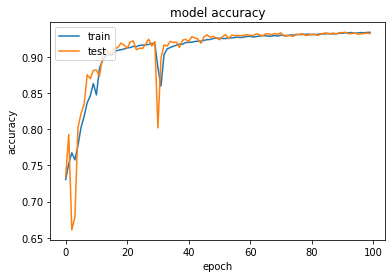

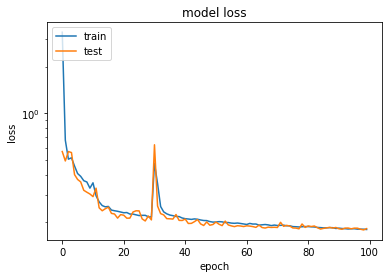

In [14]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()